<a href="https://colab.research.google.com/github/LiterallyRicky/DataScience-A2/blob/main/Rick_RiveU7Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries:**

In [1]:
!pip install git+https://github.com/pydata/xarray.git
!pip install bambi

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-o1w3ls8s
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-o1w3ls8s
  Resolved https://github.com/pydata/xarray.git to commit 4c2540de54af8d9da4456715d7dcac6b16f330d8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev33+g4c2540de-py3-none-any.whl size=1265489 sha256=8991b8d30fbfcf7898a847f0fbd95e6dc271c7b67ce1d1ebd92840cee093400f
  Stored in directory: /tmp/pip-ephem-wheel-cache-3bsb447i/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.8 MB/s eta 0:00:00
   ━

In [2]:
!pip install preliz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 7.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb
import preliz as pz
import pymc as pm

# **Unit 7 Project: How does DMC affect the amount of burnt area caused by Forest Fires?**
---



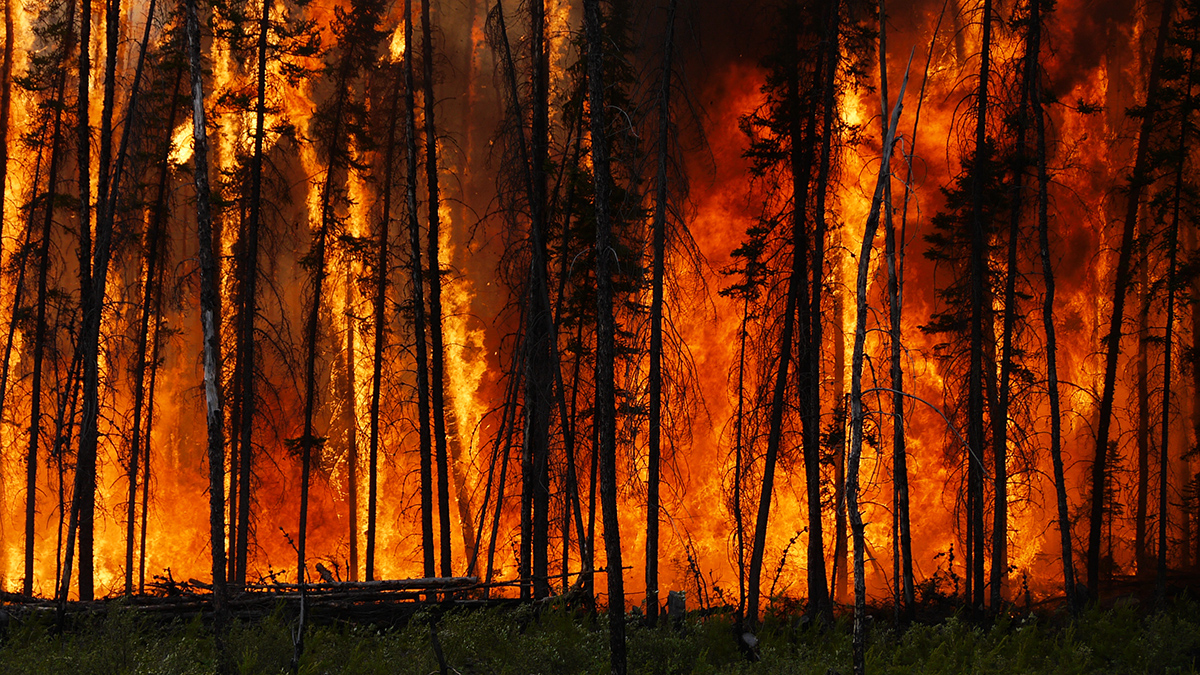

**Context:**

Forest Fires are imment throughout the entire world. In this project, I want to know what really causes forest fires, but more specifically, I want to predict the amount of area that forest fires causes with DMC. DMC? What is DMC?

"The Duff Moisture Code (DMC) is a numeric rating of the average moisture content of loosely compacted organic layers of moderate depth." (Canadian Wildland Fire Information System)

I really thought this would be amazing to look into, hopefully there's a way to model area. (Spoiler: It might be harder than anticipated.) I want to try to use a gaussian process for my models since I think gaussian processes would work pretty well on a dataset like this one!

In [4]:
f_fires = pd.read_csv("https://raw.githubusercontent.com/LiterallyRicky/DataScience-A2/refs/heads/main/Data/forestfires.csv")
f_fires

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


Cool, so we have about 13 columns with variables for forest fires. If you'd like to know more visit this website for the full details on the [dataset!](https://archive.ics.uci.edu/dataset/162/forest+fires)

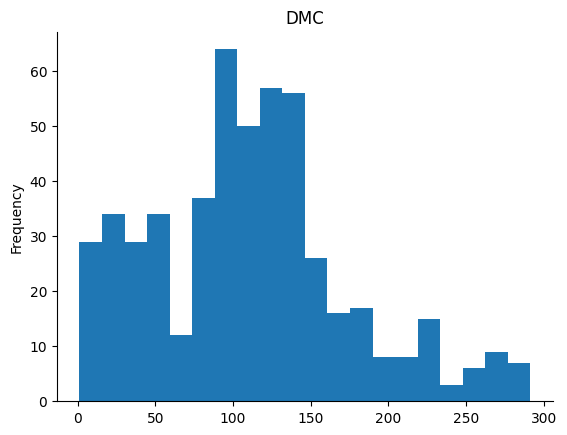

In [5]:
# @title DMC

from matplotlib import pyplot as plt
f_fires['DMC'].plot(kind='hist', bins=20, title='DMC')
plt.gca().spines[['top', 'right',]].set_visible(False)

I'm implementing this graph just to visualize some of the characterisitcs that DMC has to offer. This distribution seems to be somewhat normal/right skewed. Good to know for our model!

# **Modeling process:**

Notes from dataset: "area - the burned area of the forest (in ha): 0.00 to 1090.84
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform)."

If you're wondering why I'm implementing a logarithm transfrom to the area, it's because I tried to showcase a model but all the datapoints were skewed to zero. You'll see me using np.log to do this!

**Model 1:**

---



As I said, and from the dataset, most of the values in the 'area' column is approx. zero, which can make our model very wocky. (Trust me I know this, I tried many models but none work) So I want to try to make the log transfrom, and then implement something where if a data point is zero, it doesn't make it onto the graph. Let's see if it works.

In [6]:
f_fires = f_fires[f_fires["area"] > 0].copy()  # Remove rows where area is zero
f_fires["log_area"] = np.log(f_fires["area"])  # Apply log transform


# Extract relevant variables
x = f_fires["DMC"].values[:, None]  # Use temperature as a predictor
y = f_fires["log_area"].values  # Target variable

In [7]:
#ig stands for inverse gamma
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

I'm thinking of keeping the same priors for this portion as well!

In [8]:
# Define HSGP priors
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.1),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(x))
}

priors = {
    "hsgp(DMC, m=10, c=1.5)": prior_gp,
    "alpha": bmb.Prior("Normal", sigma=1)
}

In [9]:
f_fires["log_area"] = np.log(f_fires["area"])
f_fires["log_area"] -= f_fires["log_area"].min()  # Shift everything above zero

<Axes: xlabel='DMC', ylabel='log_area'>

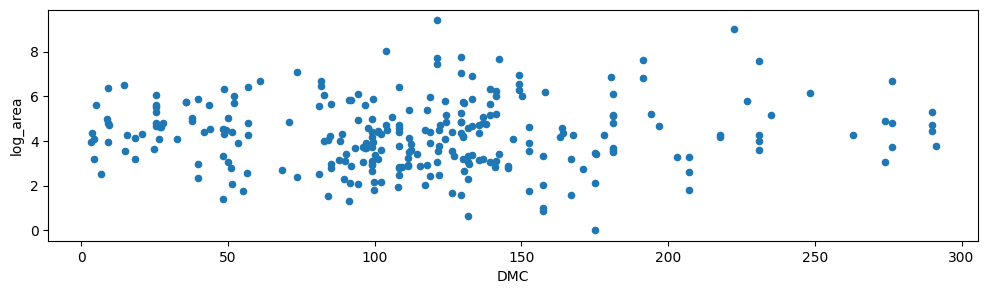

In [10]:
f_fires.plot(x="DMC", y="log_area", figsize=(12, 3), kind="scatter")

So here's a look into our scatterplot before any predictions. I can tell that this is VERY scattered. It honestly might just be a straight line for how there might not even been a correlation.

In [11]:
model_hsgp = bmb.Model("log_area ~ 0 + hsgp(DMC, m=20, c=1.5)", f_fires, family="gaussian", priors=priors)
idata_hsgp = model_hsgp.fit()

Output()

ERROR:pymc.stats.convergence:There were 40 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


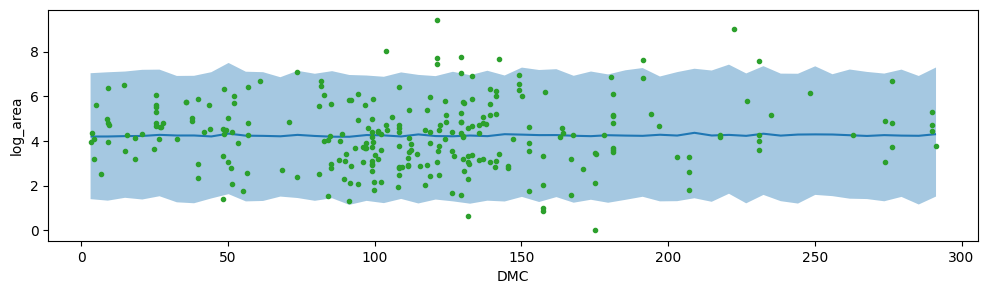

In [12]:
_, ax = bmb.interpret.plot_predictions(model_hsgp, idata_hsgp, ["DMC"],
                                       pps=True, fig_kwargs={"figsize": (12, 3)})
ax[0].plot(f_fires["DMC"].values, f_fires["log_area"].values, "C2.")

As expected, the model is just a straight line. Interesting, it could be the type of data that was collected, or it could be that DMC doesn't have an impact on area as much as I thought it would have. I mean, who knows? There could be many, multiple factors that could cause this. But for this project, I want to try to focus on capturing data using a gaussian process.

# **How does temperature affect FFMC using a gaussian process?**

Since that didn't really work with area, let's change the project a bit. Here's some context:

So, I'm thinking of modeling another abbreviation variable - FFMC. The Fine Fuel Moisture Code (FFMC) is a numeric rating of the moisture content of litter and other cured fine fuels.

Okay, so what would impact this? I think the most relevant variable would definitely have to be temperature. But to make sure it has some type of correlation, let's see it in a scatterplot.

**Model 2:**

---



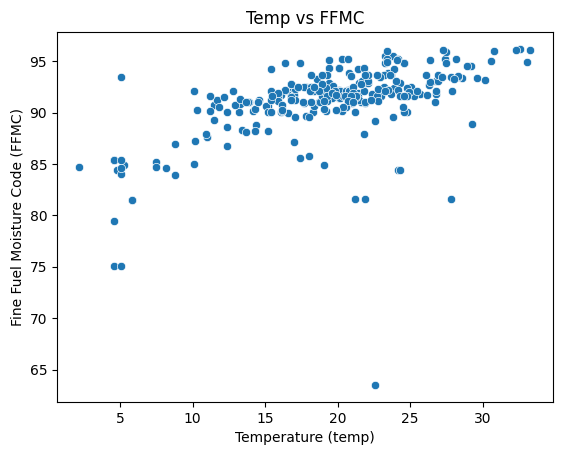

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of temp vs FFMC
sns.scatterplot(x=f_fires["temp"], y=f_fires["FFMC"])
plt.title("Temp vs FFMC")
plt.xlabel("Temperature (temp)")
plt.ylabel("Fine Fuel Moisture Code (FFMC)")
plt.show()

Okay, first thing I notice is that there's definitely some type of correlation, which almost looks like a log distribution type of model. With this information, I want to use a distribution that Bambi supports, so we can see if a gaussian process can model this.

Output()

ERROR:pymc.stats.convergence:There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(0.0, 40.0)

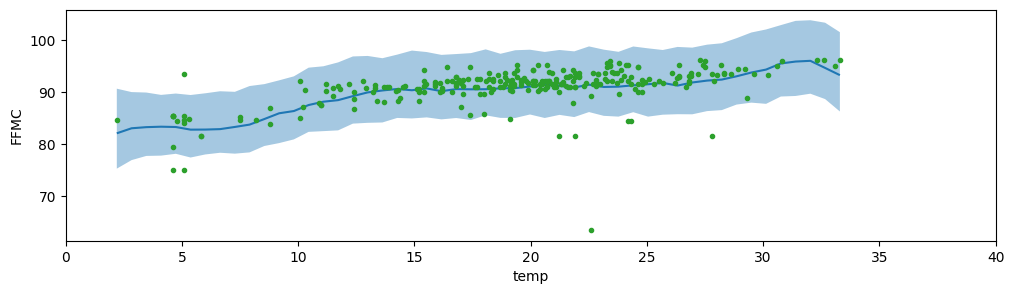

In [14]:
import bambi as bmb

# Define your data variables
x1 = f_fires["temp"].values  # Use temp as the predictor
y1 = f_fires["FFMC"].values  # Target variable

# Define HSGP priors
prior_gp2 = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.5),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(x1))  # Ensure get_ig_params(x1) works correctly
}

priors2 = {
    "hsgp(temp, m=10, c=1.5)": prior_gp2,
    "alpha": bmb.Prior("Normal", sigma=1)
}

# Fit the model with the hurdle log-normal family
model_test = bmb.Model("FFMC ~ 0 + hsgp(temp, m=10, c=1.5)", data=f_fires, family="hurdle_lognormal", priors=priors2)
idata_test = model_test.fit()

# Plot the predictions and observed data
_, ax = bmb.interpret.plot_predictions(model_test, idata_test, ["temp"], pps=True, fig_kwargs={"figsize": (12, 3)})

# Plot the observed data on the same axis
ax[0].plot(f_fires["temp"].values, f_fires["FFMC"].values, "C2.", label="Observed Data")
ax[0].set_xlim(0, 40)  # Set x-axis limits

This model looks amazing! It fits the observed data really well and it think it captures the two variables well! I think a big part of this model working is the fact of the use of "hurdle_lognormal" family was a great interpetion of the model characteristics and why it worked.